<a href="https://colab.research.google.com/github/nakib103/pancancer_classification/blob/master/MAIN_SCRIPT_FOR_SURV_survival_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## import packages
import numpy as np
import pandas as pd
import pickle
import math
import h5py
import gc
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.saving import hdf5_format

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix


## global variables
classes = ['GBM', 'OV', 'LUAD', 'LUSC', 'PRAD', 'UCEC', 'BLCA', 'TGCT', 'ESCA', 'PAAD', 'KIRP', 'LIHC', 'CESC', 'SARC', 'BRCA', 'THYM', 'MESO', 'COAD', 'STAD', 'SKCM', 'CHOL', 'KIRC', 'THCA', 'HNSC', 'LAML', 'READ', 'LGG', 'DLBC', 'KICH', 'UCS', 'ACC', 'PCPG', 'UVM']
shape = (144, 144)

## run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/data/data_df.pkl"
LABEL_PATH = "/content/drive/My Drive/data/label_df.pkl"
SURV_DATA_PATH = "/content/drive/My Drive/pancancer_classification_wip/__Data/main/TCGA-CDR.xlsx"
MODEL_PATH = "/content/drive/My Drive/pancancer_classification_wip/__Results/survival_dnn/conv_2D_pan_surv_DNN_"
METADATA_PATH = "/content/drive/My Drive/pancancer_classification_wip/__Results/survival_dnn/conv_2D_pan_surv_DNN_metadata"

MAX_OS = 12000

Mounted at /content/drive


In [31]:
class SurvDatasetGenerator:
  def __init__(self, surv_data_path, gene_exp_data_path, gene_exp_label_path):
    self.surv_data_path = surv_data_path
    self.gene_exp_data_path = gene_exp_data_path
    self.gene_exp_label_path = gene_exp_label_path

  def load_data(self):
    surv_data = pd.read_excel(self.surv_data_path, index_col=1, sheet_name='TCGA-CDR')
    gene_exp_data = pd.read_pickle(self.gene_exp_data_path)
    gene_exp_label = pd.read_pickle(self.gene_exp_label_path)

    return surv_data, gene_exp_data, gene_exp_label
  
  def filter_surv_data(self, surv_data, gene_exp_data, add_columns):
    # filter the gene exp data according to survival data we have
    # NB: for multiple sample of a patient - only the first one is enlisted
    for col in add_columns:
      gene_exp_data.insert(len(gene_exp_data.columns), col, None)

    for patient_idx in surv_data.index:
      for sample_idx in gene_exp_data.index:
        if patient_idx in sample_idx:
          for col in add_columns:
            gene_exp_data.loc[sample_idx, col] = surv_data.loc[patient_idx, col]
          break

    # drop the rows that does not have survival data information
    gene_exp_data = gene_exp_data.dropna()

    return gene_exp_data

  def generate(self):
    # load all the data from drive
    surv_data, gene_exp_data, gene_exp_label = self.load_data()

    # merge gene exp label and data dataframes
    gene_exp_label = gene_exp_label.rename(columns={0 : 'cancer_type'})
    if gene_exp_data.columns[-1] != 'cancer_type':
      gene_exp_data = gene_exp_data.merge(gene_exp_label, left_index=True, right_index=True)

    # drop row with invalid vital status
    surv_data = surv_data.drop(surv_data.index[surv_data['vital_status'] == '[Discrepancy]'])
    
    # filter & merge gene exp data according to the survival data we have
    data = self.filter_surv_data(surv_data, gene_exp_data, add_columns=['OS.time', 'vital_status'])
    
    del surv_data
    del gene_exp_data
    del gene_exp_label

    return data
  
# generate barplot for cendored and dead patient
def generate_count_barplot(data):
  censored = data[data.vital_status == 'Alive'].groupby('cancer_type').size()
  total = data.groupby('cancer_type').size()

  plt.figure(figsize=[50, 20])
  plt.rcParams.update({'font.size': 30})
  plt.xticks(fontsize=25)
  plt.yticks(fontsize=30)

  cancer_class = censored.index
  deaths = total - censored

  for i in range(len(cancer_class)):
      plt.bar(cancer_class[i], total[i], color='blue')
      plt.bar(cancer_class[i], deaths[i], color='red')

  plt.legend(labels = ['Censored Patient Count','Dead Patient Count'])
  plt.xlabel('Cancer Type')
  plt.ylabel('Counts')

  # plt.savefig('3BarPlot.png')
  plt.show()

def generate_ostime_boxplot(data):
  plt.figure(figsize=[50, 20])
  plt.rcParams.update({'font.size': 30})
  plt.xticks(fontsize=25)
  plt.yticks(fontsize=30)
  
  sns.boxplot(x=data["cancer_type"], y=data["OS.time"], hue=data["vital_status"])

  plt.xlabel('Cancer Type')
  plt.ylabel('Overall Survival Time')

  plt.show()

class SurvDatasetProcessor:
  def create_ymat(self, data):
    size = len(data.index)
    y_mat = np.zeros((size, size + 1))                                   # HERE                 

    for i, patient_os in enumerate(data['OS.time']):
      for j, other_os in enumerate(data['OS.time']):
        if other_os >= patient_os:
          y_mat[i, j] = 1

    for i in range(len(data.index)):                                    # HERE
      if data.vital_status[i] == 'Dead':
        y_mat[i, -1] = 1

    return y_mat
  
  def create_x(self, data):
    x = data.iloc[:, :-3].apply(lambda x: np.log2(x + 1))            # HERE
    x = x.iloc[:].values
    # x = ( x / np.max(x) ) * 255
    x = x.astype(int)

    return x

  def process(self, data):
    y_mat = self.create_ymat(data)
    x = self.create_x(data)

    return x, y_mat

class SurvDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, s_x=None, y_mat=None, batch_size=32, shuffle=False):
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.array([i for i in range(x.shape[0])])

  def __len__(self):
    return x.shape[0] // self.batch_size

  def __getitem__(self, index):
    # indexes = [i for i in range((index)*self.batch_size, (index + 1)*self.batch_size)]
    indexes = self.indexes[(index)*self.batch_size : (index + 1)*self.batch_size]
    x, y = self.__data_generator(indexes)

    return x, y
  
  def on_epoch_end(self):
    if self.shuffle:
      shuffled = np.random.permutation(len(self.indexes))
      self.indexes = self.indexes[shuffled]

  def __data_generator(self, indexes):
    y = np.zeros((self.batch_size, self.batch_size + 1))
    yv, xv = np.meshgrid(indexes, indexes)

    y[:, :-1] = y_mat[xv, yv]                       # HERE
    y[:, -1] = y_mat[indexes, -1]                   # HERE
    
    return x[indexes, :], y

class SurvModelGenerator:
  def __init__(self, dropout_rate):
    self.dropout_rate = dropout_rate

  def build(self):
    regularizer = regularizers.l1_l2(l1=0.00, l2=0.000)
    initializer = initializers.random_normal(mean=0.0, stddev=0.02, seed=None)
    
    model = Sequential()
    # model.add(Dense(units = 144, kernel_regularizer=regularizer))
    # model.add(Dropout(rate = self.dropout_rate))
    model.add(Dense(units = 1, input_shape=((20531, ))))
    
    return model

def neg_log_likelihood(y, y_pred):
  return -tf.math.reduce_mean(tf.multiply(y[:, -1],y_pred - tf.math.log(tf.keras.backend.dot(y[:, :-1], tf.math.exp(y_pred)))))
  
def concordance_index(y_true, y_pred):
  size = len(y_true.index)
  permissible_pair = 0
  concoudant_pair = 0
  risk_tie = 0

  for i in range(size):
    # print(i)
    for j in range(i+1, size):
      if y_true.vital_status[i] == 'Alive' and (y_true.vital_status[j] == 'Alive' or y_true['OS.time'][i] < y_true['OS.time'][j]):
        continue
      elif (y_true['OS.time'][i] > y_true['OS.time'][j] and y_pred[i] < y_pred[j]) or (y_true['OS.time'][i] < y_true['OS.time'][j] and y_pred[i] > y_pred[j]) or (y_true['OS.time'][i] == y_true['OS.time'][j] and y_pred[i] == y_pred[j]):
        permissible_pair += 1
        concoudant_pair += 1
      elif y_true['OS.time'][i] == y_true['OS.time'][j] or y_pred[i] == y_pred[j]:
        permissible_pair += 1
        risk_tie += 1
      else:
        permissible_pair += 1

  return (concoudant_pair + 0.5 * risk_tie) / permissible_pair

def save_model(model, history, optimizer, batch_size, loss_function, epochs, learning_rate, momentum):
  model_path = MODEL_PATH + datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
  model.save(model_path)

  metadata_path = METADATA_PATH + datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S") + "_metadata"
  metadata = {}

  if history != None:
    metadata['history'] = history.history
  if optimizer != None:
    metadata['optimizer'] = optimizer.get_config()
  if batch_size != None:
    metadata['batch_size'] = batch_size
  if loss_function != None:
    metadata['loss_function'] = loss_function
  if epoch != None:
    metadata['epochs'] = epochs
  if learning_rate != None:
    metadata['learning_rate'] = learning_rate
  if momentum != None:
    metadata['momentum'] = momentum

  with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

In [26]:
y = tf.constant([[1., 0., 0., 1.],[1., 1., 1., 1.],[1., 0., 1.,1.]])
y_pred = tf.constant([[1.0], [5.0], [2.5]])
neg_log_likelihood(y, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.09902928>

In [3]:
MySurvDataset = SurvDatasetGenerator(SURV_DATA_PATH, DATA_PATH, LABEL_PATH)
data = MySurvDataset.generate()

In [ ]:
# data = pd.read_pickle(DATA_PATH)
# label = pd.read_pickle(LABEL_PATH)

# label = label.rename(columns={0 : 'cancer_type'})

# # merge label and data dataframes
# if data.columns[-1] != 'cancer_type':
#   data = data.merge(label, left_index=True, right_index=True)

# s_data = pd.read_excel(SURV_DATA_PATH, index_col=1, sheet_name='TCGA-CDR')
# # s_data.loc[s_data['vital_status'] == 'Alive', 'OS.time'] = MAX_OS        # HERE 

# if 'vital_status' not in data.columns:
#   data.insert(len(data.columns), "vital_status", None)
# if 'os_time' not in data.columns:                                           # HERE
#   data.insert(len(data.columns), "os_time", None)

# for patient_idx in s_data.index:
#   for sample_idx in data.index:
#     if patient_idx in sample_idx:
#       data.loc[sample_idx, 'os_time'] = s_data.loc[patient_idx, 'OS.time']
#       data.loc[sample_idx, 'vital_status'] = s_data.loc[patient_idx, 'vital_status']      # HERE
#       break

# data = data.dropna()

In [33]:
S_LEARNING_RATE = 0.0001
S_MOMENTUM = 0.1

S_OPTIMIZER = optimizers.SGD(lr=S_LEARNING_RATE, momentum=S_MOMENTUM, decay=0.0, nesterov=True)
# S_OPTIMIZER  = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
S_BATCH_SIZE = 32          # HERE
S_EPOCHS = 200

In [34]:
for i in range(1):
  print("Iteration", i)
  cancer_class = 'GBM'

  MySurvDataProcessor = SurvDatasetProcessor()
  x, y_mat = MySurvDataProcessor.process(data[data.cancer_type == cancer_class])

  MySurvModelGenerator = SurvModelGenerator(dropout_rate=0.07)
  model = MySurvModelGenerator.build()

  MySurvDataGenerator = SurvDataGenerator(batch_size=S_BATCH_SIZE, shuffle=True)
  model.compile(loss = neg_log_likelihood, optimizer = S_OPTIMIZER)
  history = model.fit(MySurvDataGenerator, validation_data = None, epochs=S_EPOCHS, verbose=1,
                                # use_multiprocessing=True,
                                # workers=4
                                )
  
  
  # y_pred = model.predict(x[data['cancer_type'] == cancer_class, :])
  y_pred = model.predict(x)
  cc_idx = concordance_index(data[['OS.time', 'vital_status']][data['cancer_type'] == cancer_class], y_pred[:, 0])
  print("c-index", cc_idx)

  del model

Iteration 0
Epoch 1/200
4/4 [==============================] - 0s 9ms/step - loss: 2.9649
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 2.6193
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 2.2002
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - loss: 2.1927
Epoch 5/200
4/4 [==============================] - 0s 14ms/step - loss: 2.1784
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 2.2373
Epoch 7/200
4/4 [==============================] - 0s 15ms/step - loss: 2.0996
Epoch 8/200
4/4 [==============================] - 0s 15ms/step - loss: 2.1465
Epoch 9/200
4/4 [==============================] - 0s 15ms/step - loss: 2.0344
Epoch 10/200
4/4 [==============================] - 0s 16ms/step - loss: 2.1153
Epoch 11/200
4/4 [==============================] - 0s 17ms/step - loss: 2.0184
Epoch 12/200
4/4 [==============================] - 0s 16ms/step - loss: 1.9983
Epoch 13/200
4/4 [====================

In [ ]:
cancer_class = 'OV'
print(cancer_class)
y_pred = model.predict(x[data['cancer_type'] == cancer_class, :])
cc_idx = concordance_index(data[['OS.time', 'vital_status']][data['cancer_type'] == cancer_class], y_pred[:, 0])
print(cc_idx)
save_model(history=history, optimizer=S_OPTIMIZER, batch_size=S_BATCH_SIZE, loss_function='neg_log_likelihood', epochs=S_EPOCHS, learning_rate=S_LEARNING_RATE, momentum=S_MOMENTUM)

INFO:tensorflow:Assets written to: /content/drive/My Drive/pancancer_classification_wip/__Results/conv_2D_pan_surv_DNNJanuary_01_2021_19_04_43/assets


In [ ]:
# cross validation
kfold = KFold(1, True, 1)
for train, test in kfold.split(data):
  data_train = data.iloc[train]

  MySurvDataProcessor = SurvDatasetProcessor()
  x, y_mat = MySurvDataProcessor.process(data_train)
  
  MySurvModelGenerator = SurvModelGenerator(dropout_rate=0.07)
  model = MySurvModelGenerator.build()

  MySurvDataGenerator = SurvDataGenerator(batch_size=S_BATCH_SIZE, shuffle=True)
  model.compile(loss = neg_log_likelihood, optimizer = S_OPTIMIZER)
  history = model.fit(MySurvDataGenerator, validation_data = None, epochs=S_EPOCHS, verbose=1,
                                # use_multiprocessing=True,
                                # workers=4
                                )
  break
  y_pred = model.predict(x)
  cc_idx = concordance_index(data_train[['OS.time', 'vital_status']], y_pred[:, 0])
  print(cc_idx)


  data_test = data.iloc[test]

  MySurvDataProcessor = SurvDatasetProcessor()
  x, y_mat = MySurvDataProcessor.process(data_test)
  
  y_pred = model.predict(x)
  cc_idx = concordance_index(data_test[['OS.time', 'vital_status']], y_pred[:, 0])
  print(cc_idx)

  break

ValueError: ignored

In [ ]:
weights = model.get_weights()

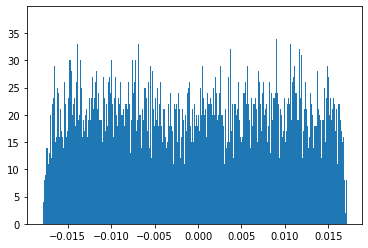

In [ ]:
plt.hist(weights[0][:, 0], bins=1000)
plt.show()

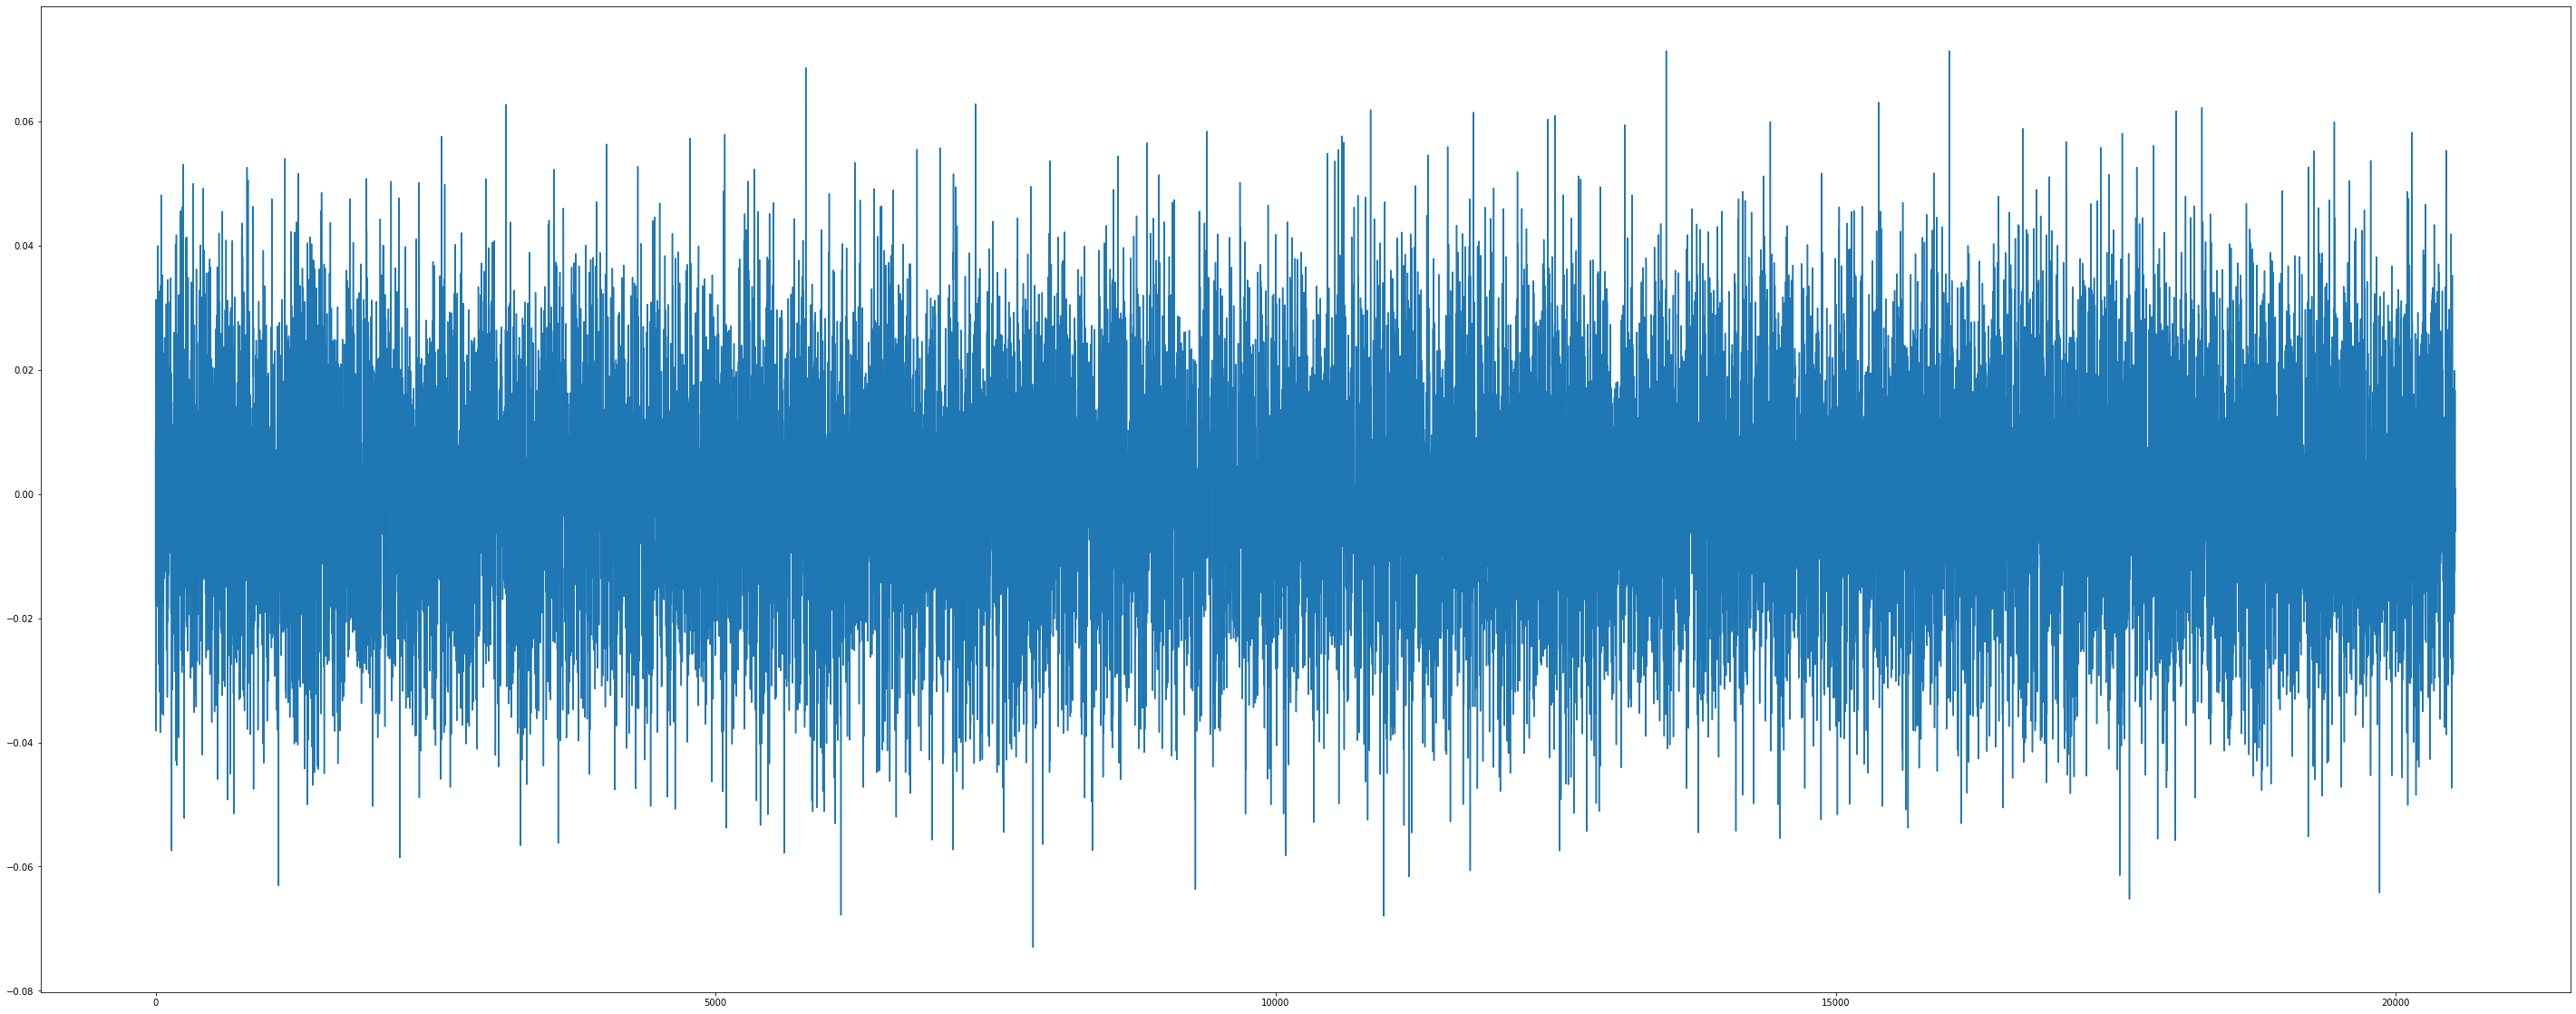

In [ ]:
plt.figure(figsize=[50, 20])
plt.plot(range(weights[0].shape[0]), weights[0][:, 0])
plt.show()

In [ ]:
MODEL_PATH = "/content/drive/My Drive/pancancer_classification_wip/__Results/survival_dnn/conv_2D_pan_surv_DNN"
model_path = MODEL_PATH + "January_01_2021_19_11_13"
model = tf.keras.models.load_model(model_path, compile=False)

MySurvDataProcessor = SurvDatasetProcessor()
x, y_mat = MySurvDataProcessor.process(data)
MySurvDataGenerator = SurvDataGenerator(batch_size=S_BATCH_SIZE, shuffle=True)

model.compile(loss = neg_log_likelihood, optimizer = S_OPTIMIZER)
model.evaluate(MySurvDataGenerator)

317/317 [==============================] - 4s 13ms/step - loss: 1.4874


1.372342824935913

In [ ]:
weights_2 = model.get_weights()

In [ ]:
weights_2

[array([[-0.00736309],
        [-0.00220397],
        [ 0.03562419],
        ...,
        [-0.00384002],
        [ 0.00496984],
        [-0.01552261]], dtype=float32), array([1.4803414e-09], dtype=float32)]

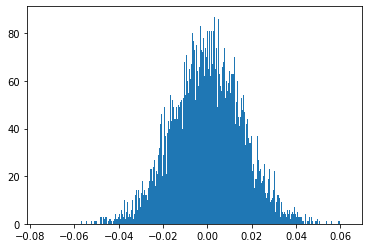

In [ ]:
plt.hist(weights_2[0][:, 0], bins=1000)
plt.show()

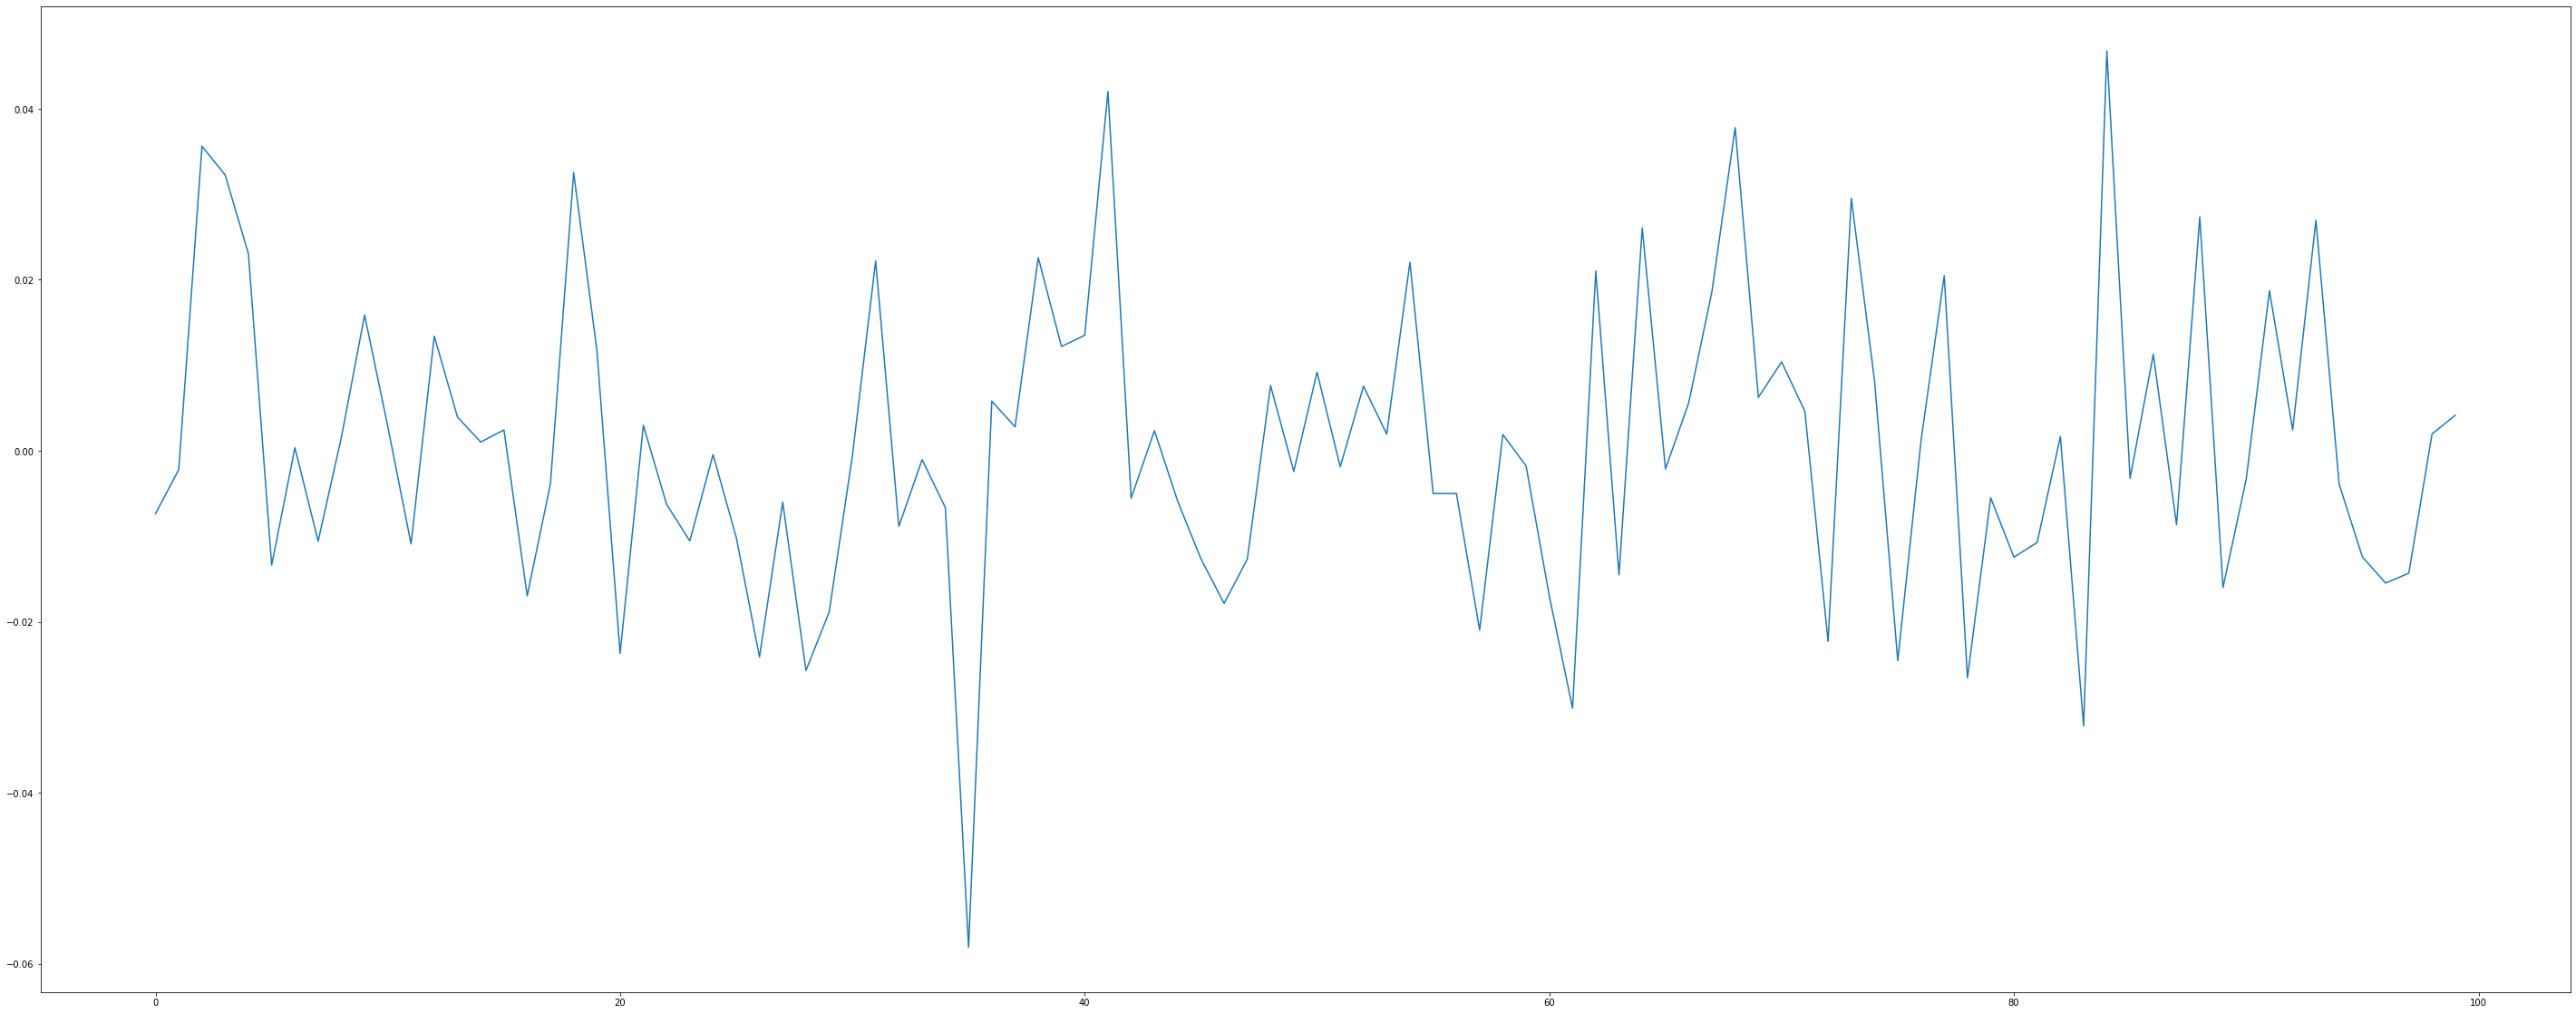

In [ ]:
plt.figure(figsize=[50, 20])
r=weights_2[0].shape[0]
r=100
plt.plot(range(r), weights_2[0][:r, 0])
plt.show()

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 20532     
Total params: 20,532
Trainable params: 20,532
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
r = 101
y_pred = model.predict(x[:r, :])
cc_idx = concordance_index(data[['OS.time', 'vital_status']][:r], y_pred[:, 0])
print(cc_idx)

0.9414182939362795
CPU times: user 207 ms, sys: 708 µs, total: 208 ms
Wall time: 208 ms


In [ ]:
%%time
# cancer_class = classes[0]
cancer_class = 'OV'
print(cancer_class)
y_pred = model.predict(x[data['cancer_type'] == cancer_class, :])
cc_idx = concordance_index(data[['OS.time', 'vital_status']][data['cancer_type'] == cancer_class], y_pred[:, 0])
print(cc_idx)

OV
0.9114339408764132
CPU times: user 1.25 s, sys: 22 ms, total: 1.27 s
Wall time: 1.26 s


In [ ]:
r = 20
y_pred = model.predict(x[:r, :])
df = pd.DataFrame({'predicted': y_pred[:, 0], 'os_time': data['OS.time'][:r]}).sort_values(by='os_time')
df

,predicted,os_time
TCGA-OR-A5J5-01A-11R-A29S-07,14.795404,365
TCGA-OR-A5JJ-01A-11R-A29S-07,14.793715,490
TCGA-OR-A5J7-01A-11R-A29S-07,14.422859,490
TCGA-OR-A5JG-01A-11R-A29S-07,13.739429,541
TCGA-OR-A5JB-01A-11R-A29S-07,14.434202,551
TCGA-OR-A5JM-01A-11R-A29S-07,14.436649,562
TCGA-OR-A5J8-01A-11R-A29S-07,14.746635,579
TCGA-OR-A5JA-01A-11R-A29S-07,12.652445,922
TCGA-OR-A5J9-01A-11R-A29S-07,11.888477,1352
TCGA-OR-A5J1-01A-11R-A29S-07,11.882294,1355


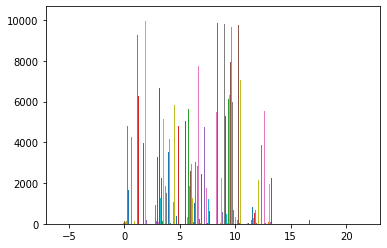

In [ ]:
plt.hist(x)
plt.show()